In [1]:
import pandas as pd

In [2]:
#Get full path of all files
def absoluteFilePaths(directory):
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            yield os.path.abspath(os.path.join(dirpath, f))

data_audio = pd.read_csv('../Handout/label_train.csv')
data_audio.File = data_audio.File.str.replace('.wav','.png')
data_audio.Label = data_audio.Label.astype(str)            

In [4]:
def png_to_wav(fn):
    return fn.replace(".png",".wav")
data_audio["File"]=data_audio["File"].apply(png_to_wav)

In [5]:
data_audio

,File,Label
0,PAEP-004139_noise.wav,0
1,PAEP-000458_stretch.wav,4
2,PAEP-004966_shift.wav,1
3,PAEP-004845_noise.wav,4
4,PAEP-004196_stretch.wav,3
...,...,...
31369,PAEP-003257_speed.wav,1
31370,PAEP-004819_noise.wav,5
31371,PAEP-002593_stretch.wav,1
31372,PAEP-004849_speed.wav,3


In [6]:
import os
import sys
from typing import Tuple
from tqdm import tqdm
import numpy as np
import scipy.io.wavfile as wav
from speechpy.feature import mfcc

mean_signal_length = 32000  # Empirically calculated for the given data set


def get_feature_vector_from_mfcc(file_path: str, flatten: bool,
                                 mfcc_len: int = 39) -> np.ndarray:
    """
    Make feature vector from MFCC for the given wav file.
    Args:
        file_path (str): path to the .wav file that needs to be read.
        flatten (bool) : Boolean indicating whether to flatten mfcc obtained.
        mfcc_len (int): Number of cepestral co efficients to be consider.
    Returns:
        numpy.ndarray: feature vector of the wav file made from mfcc.
    """
    fs, signal = wav.read(file_path)
    s_len = len(signal)
    # pad the signals to have same size if lesser than required
    # else slice them
    if s_len < mean_signal_length:
        pad_len = mean_signal_length - s_len
        pad_rem = pad_len % 2
        pad_len //= 2
        signal = np.pad(signal, (pad_len, pad_len + pad_rem),
                        'constant', constant_values=0)
    else:
        pad_len = s_len - mean_signal_length
        pad_len //= 2
        signal = signal[pad_len:pad_len + mean_signal_length]
    mel_coefficients = mfcc(signal, fs, num_cepstral=mfcc_len)
    if flatten:
        # Flatten the data
        mel_coefficients = np.ravel(mel_coefficients)
    return mel_coefficients


def get_data(flatten: bool = True, mfcc_len: int = 39) -> \
    Tuple[np.ndarray, np.ndarray]:

    data = []
    labels = []
    names = []
    
    files = list(absoluteFilePaths("../Handout/Train/"))
    for file in tqdm(files):
        name = file.split('/')[-1] 
        emotion = data_audio[data_audio["File"] == name]["Label"].item()
        feature_vector = get_feature_vector_from_mfcc(file,
                                              mfcc_len=mfcc_len,
                                              flatten=flatten)
        data.append(feature_vector)
        labels.append(emotion)
    return np.array(data), np.array(labels) 


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, Attention, ELU, Conv2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Bidirectional, CuDNNLSTM, Activation, MaxPooling2D
from tensorflow.keras.optimizers import Adam, Adadelta,Nadam,Adamax,RMSprop

def cnn(inputshape):
    model = Sequential()
    model.add(Conv2D(8, (13, 13),input_shape=(inputshape.shape[1], inputshape.shape[2], 1)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Conv2D(8, (13, 13)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Conv2D(8, (13, 13)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Conv2D(8, (2, 2)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation='softmax'))
    return model

def lstm(inputshape):
    model = Sequential()
    model.add(LSTM(512, input_shape=(inputshape.shape[1], inputshape.shape[2])))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='softmax'))
    return model

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split


_DATA_PATH = '../Handout/Train/'
_CLASS_LABELS = ("0", "1", "2", "3", "4", "5")


def extract_data(flatten):
    data, labels = get_data(flatten=flatten)
    x_train, x_test, y_train, y_test = train_test_split(
        data,
        labels,
        test_size=0.2,
        random_state=42)
    return np.array(x_train), np.array(x_test), np.array(y_train), np.array(
        y_test), len(_CLASS_LABELS)


def get_feature_vector(file_path, flatten):
    return get_feature_vector_from_mfcc(file_path, flatten, mfcc_len=39)

In [9]:
batch_size = 256
nb_epochs = 100

In [10]:
to_flatten = False
x_train, x_test, emotion_train, emotion_test, num_labels = extract_data(flatten=to_flatten)


100%|██████████| 20916/20916 [02:24<00:00, 144.59it/s]


In [53]:
model = cnn(x_train)
model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['acc'])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 186, 27, 8)        1360      
_________________________________________________________________
batch_normalization_3 (Batch (None, 186, 27, 8)        32        
_________________________________________________________________
activation_2 (Activation)    (None, 186, 27, 8)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 174, 15, 8)        10824     
_________________________________________________________________
batch_normalization_4 (Batch (None, 174, 15, 8)        32        
_________________________________________________________________
activation_3 (Activation)    (None, 174, 15, 8)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 87, 15, 8)       

In [56]:
in_shape = x_train[0].shape
x_train = x_train.reshape(x_train.shape[0], in_shape[0], in_shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], in_shape[0], in_shape[1], 1)

In [57]:
history = model.fit(x_train, emotion_train, batch_size=batch_size, epochs=nb_epochs, validation_data=(x_test, emotion_test), verbose=1)


Train on 16732 samples, validate on 4184 samples
Epoch 1/100
16732/16732 [==============================] - 12s 715us/sample - loss: 1.6236 - acc: 0.3347 - val_loss: 2.8156 - val_acc: 0.2378
Epoch 2/100
16732/16732 [==============================] - 5s 320us/sample - loss: 1.3808 - acc: 0.4463 - val_loss: 1.3983 - val_acc: 0.4264
Epoch 3/100
16732/16732 [==============================] - 5s 319us/sample - loss: 1.2706 - acc: 0.4956 - val_loss: 1.4649 - val_acc: 0.3874
Epoch 4/100
16732/16732 [==============================] - 5s 321us/sample - loss: 1.1906 - acc: 0.5323 - val_loss: 1.2781 - val_acc: 0.4849
Epoch 5/100
16732/16732 [==============================] - 5s 321us/sample - loss: 1.1206 - acc: 0.5659 - val_loss: 1.3177 - val_acc: 0.4833
Epoch 6/100
16732/16732 [==============================] - 5s 322us/sample - loss: 1.0662 - acc: 0.5905 - val_loss: 1.2374 - val_acc: 0.5124
Epoch 7/100
16732/16732 [==============================] - 5s 323us/sample - loss: 1.0016 - acc: 0.6216 

16732/16732 [==============================] - 5s 321us/sample - loss: 0.1026 - acc: 0.9652 - val_loss: 3.0173 - val_acc: 0.5139
Epoch 59/100
16732/16732 [==============================] - 5s 324us/sample - loss: 0.0942 - acc: 0.9693 - val_loss: 2.7601 - val_acc: 0.5332
Epoch 60/100
16732/16732 [==============================] - 5s 322us/sample - loss: 0.0898 - acc: 0.9684 - val_loss: 2.9658 - val_acc: 0.5194
Epoch 61/100
16732/16732 [==============================] - 5s 322us/sample - loss: 0.1114 - acc: 0.9606 - val_loss: 2.9590 - val_acc: 0.5325
Epoch 62/100
16732/16732 [==============================] - 5s 321us/sample - loss: 0.1109 - acc: 0.9613 - val_loss: 3.1171 - val_acc: 0.5141
Epoch 63/100
16732/16732 [==============================] - 5s 321us/sample - loss: 0.0925 - acc: 0.9699 - val_loss: 2.9689 - val_acc: 0.5067
Epoch 64/100
16732/16732 [==============================] - 5s 322us/sample - loss: 0.0898 - acc: 0.9696 - val_loss: 2.9394 - val_acc: 0.5270
Epoch 65/100
16732/

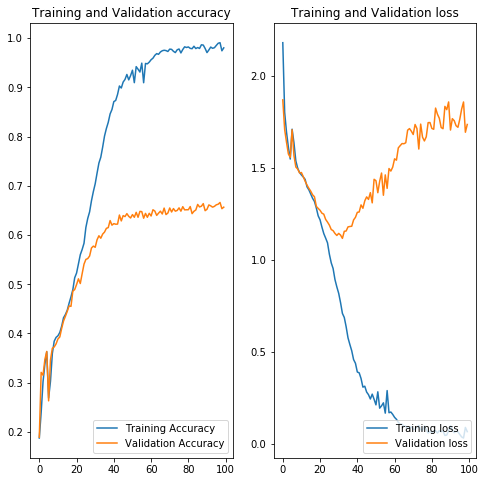

In [22]:
import matplotlib.pyplot as plt
acc = history.history["acc"]
val_acc = history.history["val_acc"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(nb_epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc="lower right")
plt.title("Training and Validation loss")
plt.savefig('../graphs/lstm_1_100epochs_augmentation.png')

In [34]:
def get_data_test(flatten: bool = True, mfcc_len: int = 39) -> \
    Tuple[np.ndarray, np.ndarray]:

    data = []
    labels = []
    names = []
    
    files = list(absoluteFilePaths("../Public_Test/Public_Test/"))
    for file in tqdm(files):
        name = file.split('/')[-1] 
        feature_vector = get_feature_vector_from_mfcc(file,
                                              mfcc_len=mfcc_len,
                                              flatten=flatten)
        data.append(feature_vector)
        names.append(name)
    return np.array(data), np.array(names) 

In [35]:
X_publictest, fname = get_data_test(flatten=to_flatten)

100%|██████████| 1106/1106 [00:05<00:00, 197.82it/s]


In [37]:
predicts = model.predict(X_publictest, batch_size=batch_size)
predicts = np.argmax(predicts, axis=1)

label = {0:'neutral', 1:'happy', 2:'sad', 3:'anger', 4:'fear', 5:'disgust'}

for i in range(32):
    print(fname[i], '-->', predicts[i])

PAEP-002135.wav --> 4
PAEP-001277.wav --> 0
PAEP-000938.wav --> 1
PAEP-000955.wav --> 1
PAEP-001190.wav --> 1
PAEP-000609.wav --> 4
PAEP-000039.wav --> 0
PAEP-000514.wav --> 0
PAEP-000949.wav --> 2
PAEP-002062.wav --> 0
PAEP-000074.wav --> 3
PAEP-001878.wav --> 3
PAEP-000355.wav --> 3
PAEP-000456.wav --> 5
PAEP-000838.wav --> 1
PAEP-001267.wav --> 5
PAEP-000861.wav --> 2
PAEP-000088.wav --> 1
PAEP-002003.wav --> 0
PAEP-002173.wav --> 5
PAEP-000318.wav --> 5
PAEP-001422.wav --> 4
PAEP-001719.wav --> 4
PAEP-000948.wav --> 5
PAEP-001945.wav --> 4
PAEP-000025.wav --> 1
PAEP-000661.wav --> 5
PAEP-002165.wav --> 4
PAEP-001446.wav --> 3
PAEP-000123.wav --> 3
PAEP-001323.wav --> 2
PAEP-001992.wav --> 5


In [38]:
submit = pd.DataFrame.from_dict({'File':fname, 'Label':predicts})
submit

,File,Label
0,PAEP-002135.wav,4
1,PAEP-001277.wav,0
2,PAEP-000938.wav,1
3,PAEP-000955.wav,1
4,PAEP-001190.wav,1
...,...,...
1101,PAEP-001879.wav,2
1102,PAEP-000393.wav,0
1103,PAEP-000761.wav,0
1104,PAEP-001269.wav,3


In [39]:
submit.to_csv('./submit7.csv', index=False)
# model.save("../model/lstm_1_augmentation.h5")